In [45]:
import numpy as np
import scipy.sparse.linalg as splin
from scipy import sparse
from scipy import linalg
import matplotlib.pyplot as plt

## helper functions

In [50]:
def printmatrix(mat, **kwargs):
    fp = kwargs.get("fp", 3)
    format_dict = {
        'float_kind': lambda x: f"{x:>10.{fp}f}",
        'bool': lambda x: False if x == 0 else True,
        }
    formatter = kwargs.get("formatter", format_dict)
    linewidth = kwargs.get("linewidth", 110)
    with np.printoptions(formatter=formatter, linewidth=linewidth):
        print(mat)

In [126]:
def initial_guess(N, eps, bound, BC):
    a, b = bound
    alpha, beta = BC
    ts = np.linspace(a, b, num=N, endpoint=True)
    tbar = 0.5 * (a + b - alpha - beta)
    w0 = 0.5 * (a - b + beta - alpha)
    u_init = lambda t, eps: t - tbar + w0 * np.tanh(w0*(t - tbar) / (2*eps))
    
    print(f"h_expected = {np.abs(ts[0] - ts[1]):.2e}")
    return u_init(ts, eps), ts

def residual(U, BC, epsilon):
    N = len(U)
    alpha, beta = BC
    h = 1/(N-1)
    F = np.zeros(shape=(N,))
    upp = (U[2:] - 2*U[1:-1] + U[:-2]) / h**2
    up  = (U[2:] - U[:-2]) / (2*h)
    
    F[1:-1] = epsilon*upp + U[1:-1]*(up - 1)
    F[0] = U[0] - alpha
    F[-1] = U[-1] - beta
    
    # print(f"         h = {h}")
    return sparse.csc_matrix(F).T

def Jacobian(U, epsilon):
    
    N = len(U)
    h = 1/(N-1)
    
    lower_diag = np.zeros(shape=(N-1, ))
    main_diag  = np.zeros(shape=(N,   ))
    upper_diag = np.zeros(shape=(N-1, ))
    
    lower_diag[:-1] =    epsilon/(h**2) - U[1:-1]/(2*h)
    main_diag[1:-1] = -2*epsilon/(h**2) + (U[2:] - U[:-2])/(2*h) - 1
    upper_diag[1:]  =    epsilon/(h**2) + U[1:-1]/(2*h)
    
    main_diag[0]  = 1
    main_diag[-1] = 1
    
    J = sparse.diags([lower_diag, main_diag, upper_diag], offsets=[-1, 0, 1], shape=(N,N), format="csc")
    return J

def Newton_iteration(U, BC, eps):
    
    F = residual(U, BC, eps)
    J = Jacobian(U, eps)
    
    DeltaU = splin.spsolve(J, -F)
    return J, U + DeltaU, F

def Newtons_method(U, BC, eps, max_iter, tol):
    
    F0 = residual(U, BC, eps)
    U_iter = U.copy()
    for iter in range(max_iter):
        ## Some advanced print-statement for counting loops.
        print(f"Running loop   : {iter+1:>{len(str(max_iter))+3},}/{max_iter:,}", end="\r")
        
        # Run an iteration of Newtons method
        J_iter, U_iter, F_iter = Newton_iteration(U_iter, BC, eps)
        
        rel_error = splin.norm(F_iter, np.inf) / splin.norm(F0, np.inf)
        if (rel_error < tol): #and (iter+1 != max_iter):
            print() # avoid overwriting the Loop counter
            print(f"## Converged   : {rel_error:.3e} < tolerance")
            break # break for-loop
        elif iter+1 == max_iter:
            print()
            print("did not converge...........")
    print()
    return J_iter, U_iter, F_iter

In [127]:
def plot_params(ax, subfig_label, title, labelsize):
    ax.set_title(title, size=labelsize+2)
    ax.legend(loc="lower right")
    ax.tick_params(axis='both', labelsize=labelsize-2)  # Set fontsize for both x and y ticks
    ax.text(0, 1, subfig_label, size=labelsize)
    ax.grid(alpha=0.8)

epsilon = 1
h_expected = 2.04e-02
Running loop   :       5/1,000
## Converged   : 7.877e-13 < tolerance

epsilon = 0.1
h_expected = 1.01e-02
Running loop   :       7/1,000
## Converged   : 9.243e-13 < tolerance

epsilon = 0.01
h_expected = 5.03e-03
Running loop   :       4/1,000
## Converged   : 2.533e-13 < tolerance

epsilon = 0.001
h_expected = 2.51e-03
Running loop   :       6/1,000
## Converged   : 4.864e-15 < tolerance



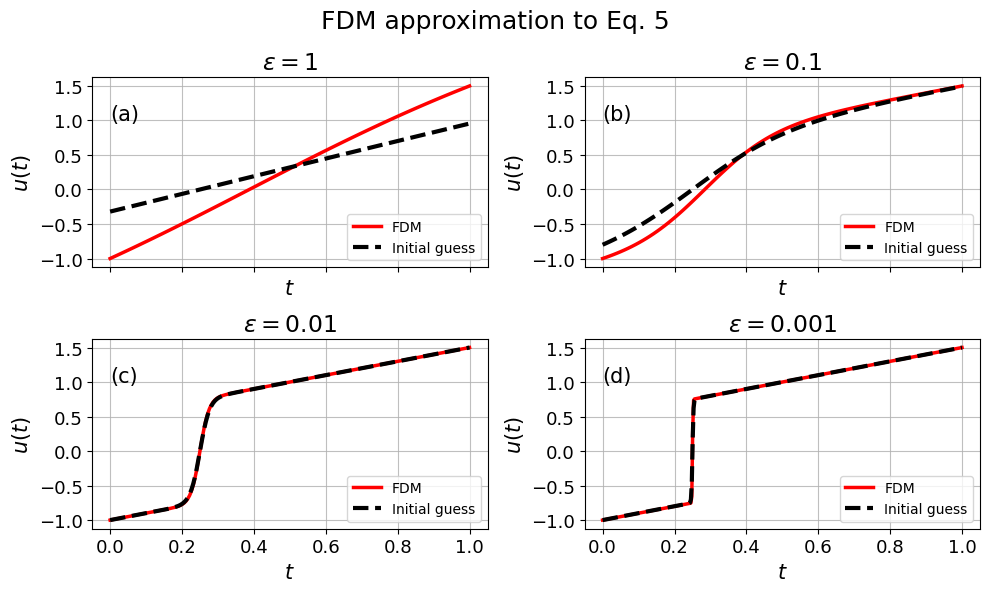

In [128]:
a, b = 0, 1 # boundary points
alpha, beta = -1, 1.5 # boundary values

# eps = 0.1
# N = 50



LABELSIZE = 15
SUBFIG_LABELS = ["(a)", "(b)", "(c)", "(d)"]



fig, ax = plt.subplots(2,2, figsize=(10,6), sharex=True, sharey=False)
ax = ax.flatten()

eps_list = [1, 0.1, 0.01, 0.001]
grid_list = [50, 100, 200, 400]
for iter, (epsilon, N) in enumerate(zip(eps_list, grid_list)):
    print(f"{epsilon = }")
    u0, ts = initial_guess(N, epsilon, bound=(a,b), BC=(alpha, beta))
    J, U, F = Newtons_method(u0, (alpha, beta), epsilon, max_iter=1_000, tol=1e-12)
    
    ax[iter].plot(ts, U, "r-", label="FDM", lw=2.5)
    ax[iter].plot(ts, u0, "k--", label="Initial guess", lw=3)
    ax[iter].set_yticks([-1, -0.5, 0, 0.5, 1, 1.5])
    
    ax[iter].set_ylabel("$u(t)$", size=LABELSIZE)
    ax[iter].set_xlabel("$t$", size=LABELSIZE)
    plot_params(ax[iter], subfig_label=SUBFIG_LABELS[iter], 
                title=fr"$\epsilon = {epsilon}$", labelsize=LABELSIZE)
    
fig.suptitle("FDM approximation to Eq. 5", fontsize=LABELSIZE+3)
fig.tight_layout()
    


In [173]:
def get_solutions(grid_list, eps_list, bound, BC, max_iter, tol):
    
    solutions = []
    # norm_solutions = []

    for (N, epsilon) in zip(grid_list, eps_list):
        print(f"{N          = :>3}")
        print(f"{epsilon    = :>5}")
        
        u0, ts = initial_guess(N, epsilon, bound, BC)
        J_h, u_h, F_h = Newtons_method(u0, BC, epsilon, max_iter, tol)
        solutions.append([N, J_h, u_h, F_h])
        
        # # lu = splin.inv(J_h)
        # # norm_A_inv = lu.solve(np.eye(N))
        # A_inv = splin.inv(J_h)
        # norm_A_inv = splin.norm(A_inv, np.inf).squeeze()
        
        # norm_tau = splin.norm(F_h, np.inf).squeeze()
        # norm_solutions.append([norm_A_inv, norm_tau])
        
    return solutions


def norm_solutions(solutions):
    
    norm_solutions = []
    
    N_ref, J_ref, U_ref, F_ref = solutions[-1]
    for N, J_h, U_h, F_h in solutions[:-1]:
        # lu = splin.inv(J_h)
        # norm_A_inv = lu.solve(np.eye(N))
        
        A_inv = splin.inv(J_h)
        norm_A_inv = splin.norm(A_inv, np.inf).squeeze()
        
        norm_tau = splin.norm(F_h, np.inf).squeeze()
        
        norm_err = np.abs(U_h[ N//2 ] - U_ref[ N_ref // 2]).squeeze()
        
        norm_solutions.append([N, norm_A_inv, norm_err, norm_tau])
    
    return np.array(norm_solutions).squeeze()
        
        
    
        
grid_list=[20, 40, 80, 160, 320]
solutions = get_solutions(grid_list=[20, 40, 80, 160, 320, 640], eps_list=[0.1,]*len(grid_list), 
                                 bound=(a,b), BC=(alpha, beta), 
                                 max_iter=1_000, tol=1e-11)

norms = norm_solutions(solutions)
norms

N          =  20
epsilon    =   0.1
h_expected = 5.26e-02
Running loop   :       5/1,000
## Converged   : 5.571e-13 < tolerance

N          =  40
epsilon    =   0.1
h_expected = 2.56e-02
Running loop   :       5/1,000
## Converged   : 7.325e-13 < tolerance

N          =  80
epsilon    =   0.1
h_expected = 1.27e-02
Running loop   :       5/1,000
## Converged   : 1.046e-12 < tolerance

N          = 160
epsilon    =   0.1
h_expected = 6.29e-03
Running loop   :       5/1,000
## Converged   : 2.946e-12 < tolerance

N          = 320
epsilon    =   0.1
h_expected = 3.13e-03
Running loop   :      24/1,000
## Converged   : 9.974e-12 < tolerance



array([[2.00000000e+01, 5.32270739e+00, 6.42558693e-02, 1.92956762e-13],
       [4.00000000e+01, 5.25112906e+00, 2.85040296e-02, 2.47801779e-13],
       [8.00000000e+01, 5.23185403e+00, 1.18847730e-02, 3.51940699e-13],
       [1.60000000e+02, 5.22615291e+00, 3.90546360e-03, 9.89684029e-13]])

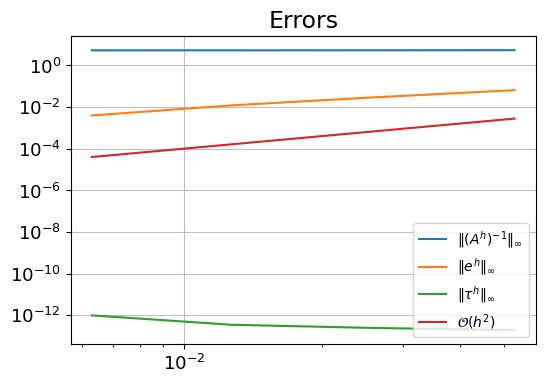

In [175]:
Ns = norms[:, 0]
hs = 1/(Ns - 1)
fig, ax = plt.subplots( figsize=(6,4))
ax.loglog(hs, norms[:, 1], label=r"$\|\left(A^h\right)^{-1}\|_\infty$")
ax.loglog(hs, norms[:, 2], label=r"$\| e^h\|_\infty$")
ax.loglog(hs, norms[:, 3], label=r"$\| \tau^h \|_\infty$")
ax.loglog(hs, hs**2, label=r"$\mathcal{O}(h^2)$")
ax.legend()
plot_params(ax, "", "Errors", LABELSIZE)
